In [1]:
# merge two recordings (BL and stimulation) from the same population
# load both datasets, pre-process separately, detect spikes, 
# cluster separately, cluster average spike from BL with average spike from stim

In [2]:
from NewLibraryENG import *

In [5]:
name_data_BL = '2019-01-23T11-41-41Pop1 healthy cortical .h5'
name_data_st = '2019-01-24T16-00-33Pop1 24hour after.h5'

complete_string_BL='/Users/Gaia_1/Desktop/h5files/'+name_data_BL
complete_string_st='/Users/Gaia_1/Desktop/h5files/'+name_data_st

In [6]:
#Baseline
data = h5py.File(complete_string_BL,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_BL = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_BL.shape)

(5020000, 60)


In [7]:
# Stimulation
data = h5py.File(complete_string_st,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_st = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_st.shape)

(4228000, 60)


In [39]:
inizio=0
len_data=1920000 #192 secondi
#len_data=len(readings)
ref_BL=readings_BL[b'Ref']
ref_st=readings_st[b'Ref']
prova_BL=readings_BL.drop([b'Ref'],axis=1)
prova_st=readings_st.drop([b'Ref'],axis=1)
prova_BL=prova_BL.iloc[inizio:len_data, 1:4]
prova_st=prova_st.iloc[inizio:len_data, 1:4]
ref_BL=ref_BL[inizio:len_data]
ref_st=ref_st[inizio:len_data]

print(prova_BL.shape,ref_BL.shape,prova_st.shape,ref_st.shape)
prova_BL

(1920000, 3) (1920000,) (1920000, 3) (1920000,)


Label,b'48',b'46',b'45'
0,-125,-99,-24
1,-107,-122,29
2,-152,-177,-75
3,-155,-147,-79
4,-79,-30,6
...,...,...,...
1919995,21,32,12
1919996,25,43,45
1919997,5,59,31
1919998,-314,-264,-292


In [40]:
prova_st

Label,b'48',b'46',b'45'
0,94,71,65
1,58,-36,49
2,58,-5,0
3,83,81,65
4,107,118,93
...,...,...,...
1919995,72,106,108
1919996,8,30,36
1919997,-92,-54,-3
1919998,-96,20,-13


In [42]:
#BL
prova=prova_BL

prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_BL)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
prova_BL=filt_prova
prova_BL.shape

  0%|          | 0/3 [00:00<?, ?it/s]

(1920000, 3)

In [43]:
#stim
prova=prova_st

prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_st)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
prova_st=filt_prova
prova_st.shape

  0%|          | 0/3 [00:00<?, ?it/s]

(1920000, 3)

In [44]:
prova_st.index+=1920000
prova_st.index

RangeIndex(start=1920000, stop=3840000, step=1)

In [45]:
mer=pd.concat([prova_BL,prova_st],axis=0)
mer

Label,b'48',b'46',b'45'
0,-1.770590,-1.417637,-1.653078
1,0.129284,-38.099339,30.383350
2,-15.475870,-62.114068,-11.277769
3,16.861083,0.522294,-0.742927
4,47.798657,77.327821,58.275710
...,...,...,...
3839995,128.034200,109.859571,100.541303
3839996,55.433740,18.932237,29.799080
3839997,-30.827914,-29.432807,-32.100677
3839998,-43.505296,-7.604388,-26.895627


In [46]:
mer.index

RangeIndex(start=0, stop=3840000, step=1)

In [47]:
switch_index=1920000

In [48]:
prova=prova_BL
pos_ind=[]
neg_ind=[]
for electrode in tqdm(prova.columns):
    channel=prova[electrode]
    pos, neg=find_all_spikes(channel)
    pos_ind_BL.append(pos)
    neg_ind_BL.append(neg)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3830000 [00:00<?, ?it/s]

positive spikes 7912 negative spikes 50506 detected spikes: 58418 firing rate:  152.13020833333334


  0%|          | 0/3830000 [00:00<?, ?it/s]

positive spikes 7964 negative spikes 50243 detected spikes: 58207 firing rate:  151.58072916666666


  0%|          | 0/3830000 [00:00<?, ?it/s]

positive spikes 7825 negative spikes 50687 detected spikes: 58512 firing rate:  152.375


In [ ]:
prova=prova_st
pos_ind=[]
neg_ind=[]
for electrode in tqdm(prova.columns):
    channel=prova[electrode]
    pos, neg=find_all_spikes(channel)
    pos_ind_st.append(pos)
    neg_ind_st.append(neg)

In [49]:
pos_cut=[]
neg_cut=[]
n_pos=[]
n_neg=[]

for i,electrode in enumerate(tqdm(prova.columns)):
    pos=pos_ind[i]
    neg=neg_ind[i]
    channel=prova[electrode]
    pos_cut1,n_pos1, neg_cut1,n_neg1 = cut(pos,neg,channel)
    pos_cut.append(pos_cut1)
    neg_cut.append(neg_cut1)
    n_pos.append(n_pos1)
    n_neg.append(n_neg1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

  0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
for i in (tqdm(range(len(pos_cut)))):
    pos_cut[i]=mask_cuts(pos_cut[i])
    neg_cut[i]= mask_cuts(neg_cut[i])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Total spikes:  7912
For 3 clusters, the silhouette score is: 0.133
For 4 clusters, the silhouette score is: 0.201
For 5 clusters, the silhouette score is: 0.199
For 6 clusters, the silhouette score is: 0.252
For 7 clusters, the silhouette score is: 0.266
For 8 clusters, the silhouette score is: 0.273
For 9 clusters, the silhouette score is: 0.273
For 10 clusters, the silhouette score is: 0.271
For 11 clusters, the silhouette score is: 0.264
For 12 clusters, the silhouette score is: 0.235
For 13 clusters, the silhouette score is: 0.234
For 14 clusters, the silhouette score is: 0.235


Best cluster in the range 3 to  14 :  9 , with a silhouette score of:  0.2726957628029583   


firing rate threshold:  0.8827362205629112


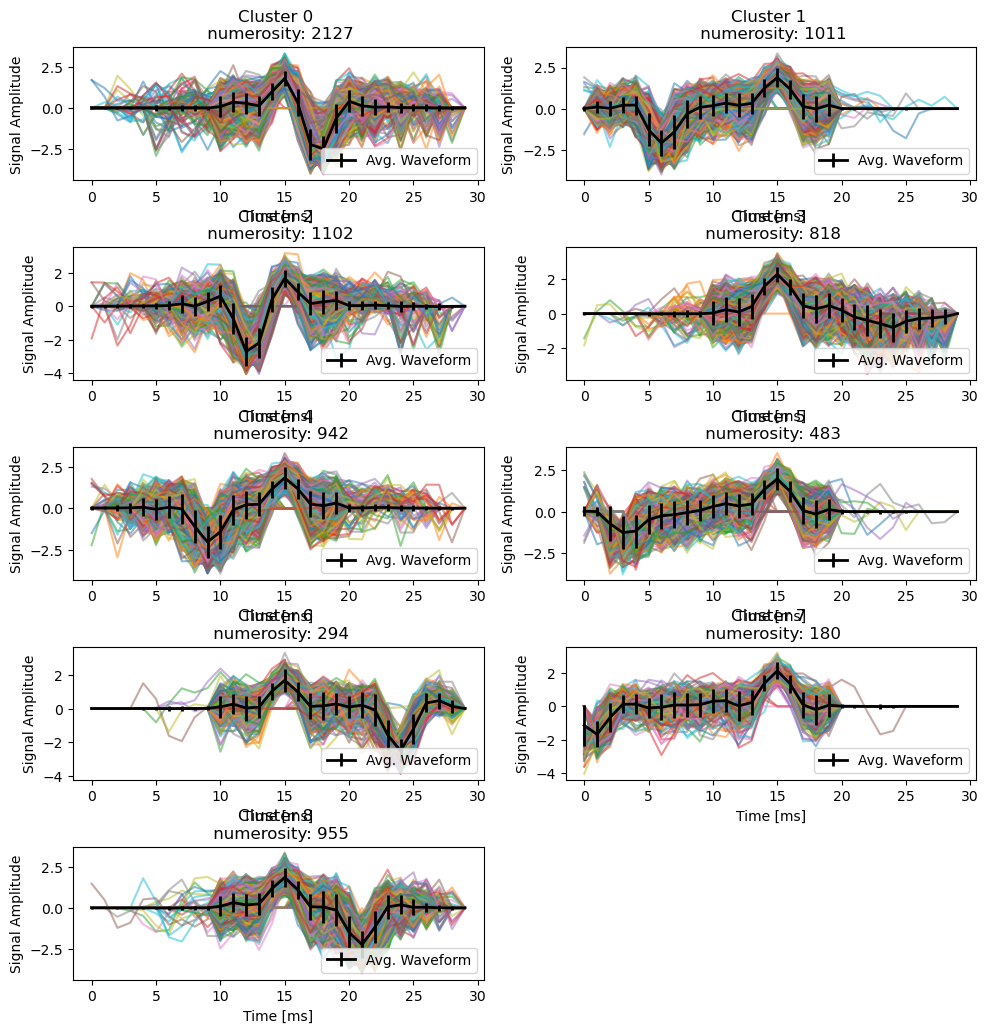

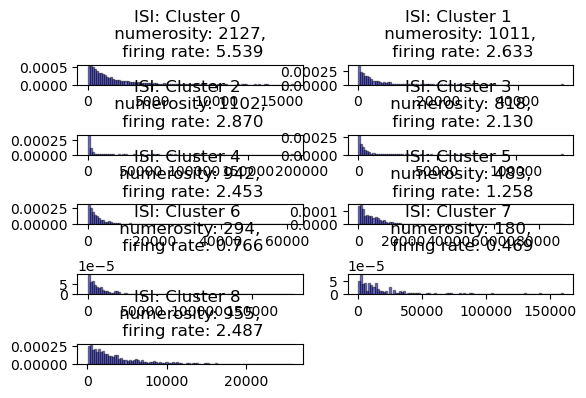

Total spikes:  7964
For 3 clusters, the silhouette score is: 0.166
For 4 clusters, the silhouette score is: 0.193
For 5 clusters, the silhouette score is: 0.224
For 6 clusters, the silhouette score is: 0.250
For 7 clusters, the silhouette score is: 0.274
For 8 clusters, the silhouette score is: 0.272
For 9 clusters, the silhouette score is: 0.294
For 10 clusters, the silhouette score is: 0.227
For 11 clusters, the silhouette score is: 0.233
For 12 clusters, the silhouette score is: 0.247
For 13 clusters, the silhouette score is: 0.239
For 14 clusters, the silhouette score is: 0.226


Best cluster in the range 3 to  14 :  9 , with a silhouette score of:  0.2937279570899093   


firing rate threshold:  1.26899711035137


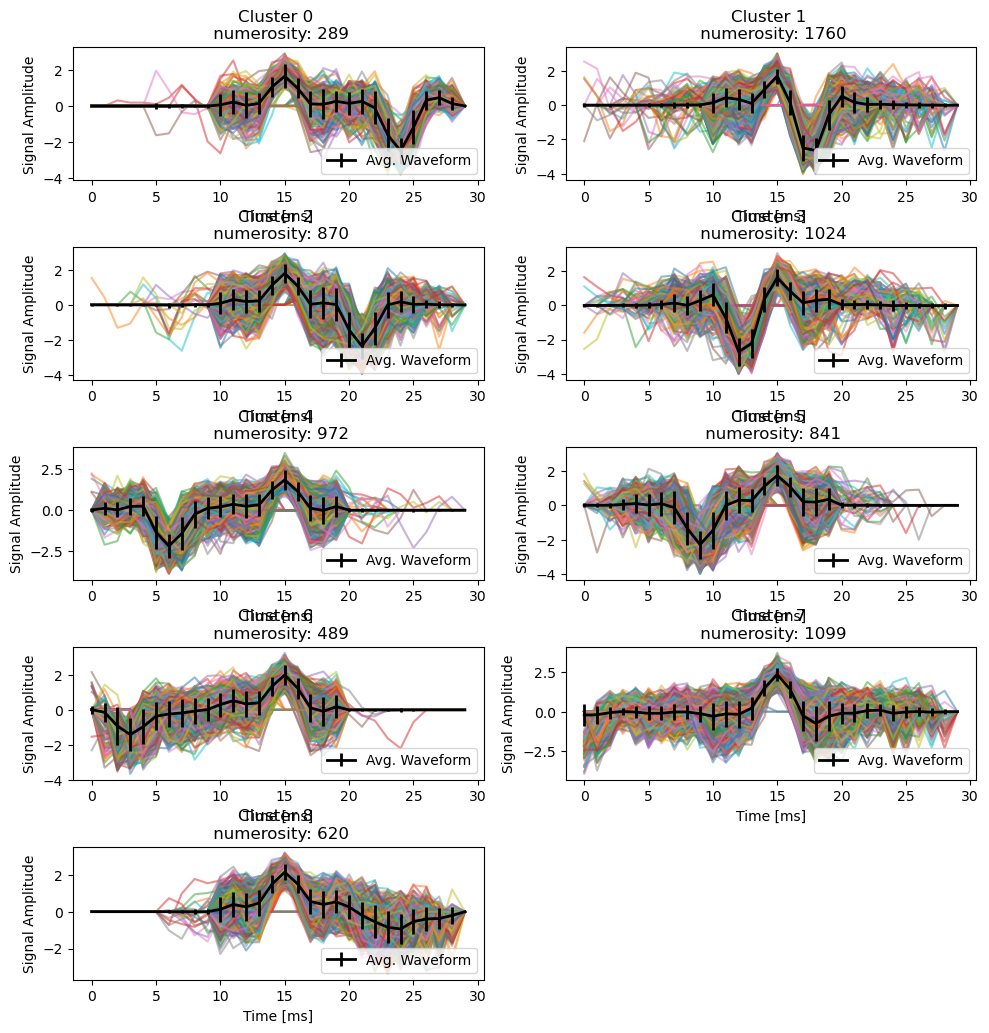

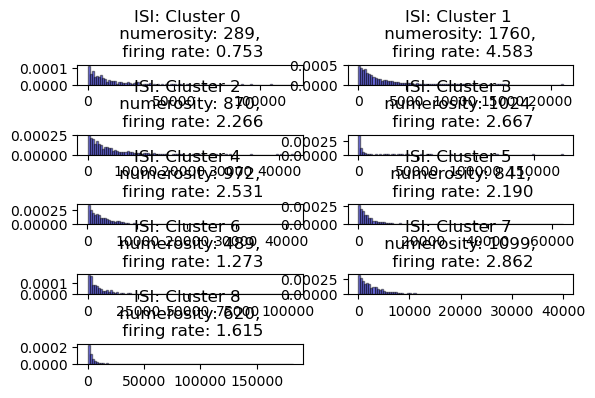

Total spikes:  7825
For 3 clusters, the silhouette score is: 0.163
For 4 clusters, the silhouette score is: 0.187
For 5 clusters, the silhouette score is: 0.217
For 6 clusters, the silhouette score is: 0.218
For 7 clusters, the silhouette score is: 0.270
For 8 clusters, the silhouette score is: 0.277
For 9 clusters, the silhouette score is: 0.291
For 10 clusters, the silhouette score is: 0.292
For 11 clusters, the silhouette score is: 0.265
For 12 clusters, the silhouette score is: 0.277
For 13 clusters, the silhouette score is: 0.228
For 14 clusters, the silhouette score is: 0.245


Best cluster in the range 3 to  14 :  10 , with a silhouette score of:  0.29247213212492523   


firing rate threshold:  0.8190342049597215


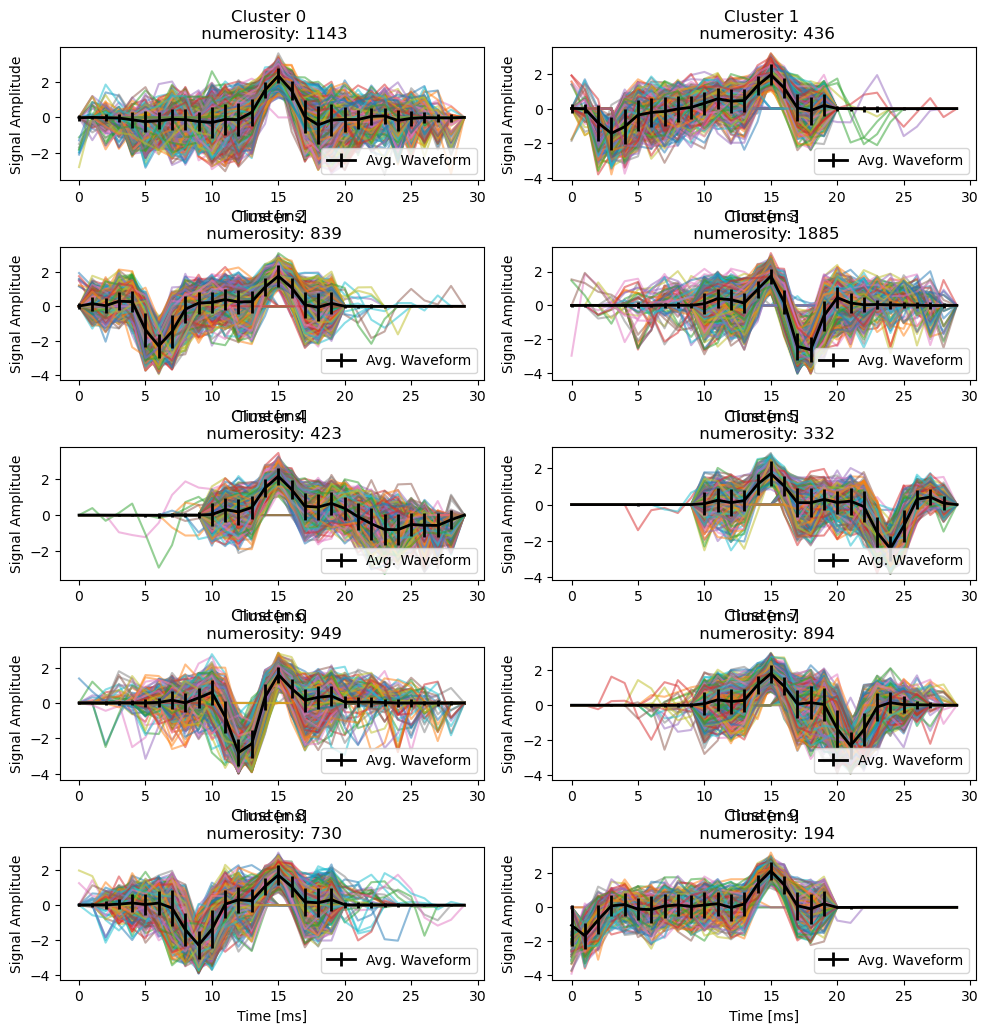

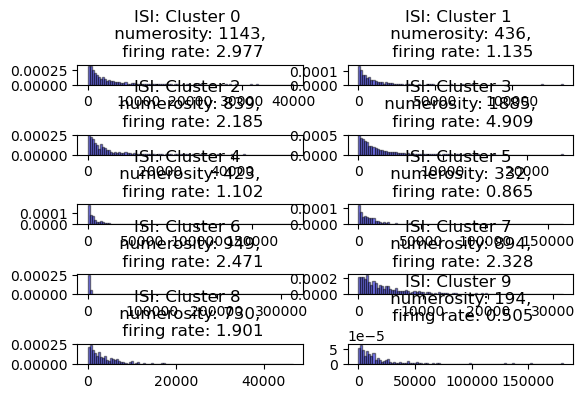

In [51]:
final_data_pos=[]
for channel in (tqdm(range(len(pos_cut)))):
    channel_clusters=clus(pos_cut[channel],'kmeans',n_pos[channel],prova.iloc[:,channel])
    final_data_pos.append(channel_clusters)

In [54]:
final_data_neg=[]

for channel in (tqdm(range(len(neg_cut)))):
    channel_clusters=clus(neg_cut[channel],'kmeans',n_neg[channel],prova.iloc[:,channel])
    final_data_neg.append(channel_clusters)

  0%|          | 0/3 [00:00<?, ?it/s]

Total spikes:  50506


KeyboardInterrupt: 